In [1]:
#%%capture

# @title Install MuJoCo
!pip install mujoco
#@title Check if installation was successful

# from google.colab import files

import distutils.util
import os
import subprocess
# if subprocess.run('nvidia-smi').returncode:
#   raise RuntimeError(
#       'Cannot communicate with GPU. '
#       'Make sure you are using a GPU Colab runtime. '
#       'Go to the Runtime menu and select Choose runtime type.')

# # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# # This is usually installed as part of an Nvidia driver package, but the Colab
# # kernel doesn't install its driver via APT, and as a result the ICD is missing.
# # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
# NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
# if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
#   with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
#     f.write("""{
#     "file_format_version" : "1.0.0",
#     "ICD" : {
#         "library_path" : "libEGL_nvidia.so.0"
#     }
# }
# """)

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

#@title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# Torch setup
import torch
from torch import nn, zeros
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
from collections import deque
import random
import copy

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:


/tmp/ipykernel_2837201/3423265580.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.util


Installation successful.
Installing mediapy:


2025-04-18 07:56:02.825857: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-18 07:56:02.933718: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-18 07:56:02.933784: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-18 07:56:02.943085: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-18 07:56:02.978490: I tensorflow/core/platform/cpu_feature_guar

Using device: cuda


In [2]:
# @title Load simple connector MJCF as `xml`
xml ="""
<mujoco>
  <default>
    <geom density="10" solimp="0.0 0.1 0.1 0.5 2"/>
    <!-- <geom solimp="0.0 0.1 0.1 0.5 2" /> -->
  </default>

  <visual>
    <map force="0.1"/>
    <headlight ambient="0.7 0.7 0.7"/>
    <rgba contactforce="0.7 1.0 1.0 .6"/>
  </visual>

  <visual>
  <global offwidth="1024" offheight="1024"/>
  <rgba haze="0.15 0.25 0.35 1"/>
</visual>


  <option>
    <flag gravity="disable"/>
  </option>


<asset>
    <texture type="skybox" builtin="gradient" rgb1=".3 .5 .7" rgb2="0 0 0" width="32" height="512"/>
    <texture name="body" type="cube" builtin="flat" mark="cross" width="128" height="128" rgb1="0.8 0.6 0.4" rgb2="0.8 0.6 0.4" markrgb="1 1 1" random="0.01"/>
    <material name="body" texture="body" texuniform="true" rgba="0.8 0.6 .4 1"/>
    <texture name="grid" type="2d" builtin="checker" width="512" height="512" rgb1=".1 .2 .3" rgb2=".2 .3 .4"/>
    <material name="grid" texture="grid" texrepeat="1 1" texuniform="true" reflectance="0."/>
  </asset>

  <worldbody>
    <light diffuse=".5 .5 .5" pos="0 0 3" dir="0 0 -1"/>
    <geom name="floor" pos="0 0 -3" size="0 0 0.05" type="plane" material="grid"/>
    <light name="spotlight" mode="targetbodycom" target="m" diffuse=".8 .8 .8" specular="0.3 0.3 0.3" pos="0 -6 4" cutoff="30"/>
    <body name="f" >
      <body name = "fb1" >
        <geom name="fb1" size=".075" pos=".5 .45 0" rgba="0 0 1 1" priority="1"  friction=".6 0.005 0.0001"/>
      </body>
      <body name = "fb2" >
        <geom name="fb2" size=".075" pos="-.5 .45 0" rgba="0 0 1 1" priority="1"  friction=".6 0.005 0.0001"/>
      </body>
      <body name = "fb3" >
        <geom name="fb3" size=".075" pos=".5 -.45 0" rgba="0 0 1 1" priority="1"  friction=".6 0.005 0.0001"/>
      </body>
      <body name = "fb4" >
        <geom name="fb4" size=".075" pos="-.5 -.45 0" rgba="0 0 1 1" priority="1"  friction=".6 0.005 0.0001"/>
      </body>
      <geom name="left" type="box" pos="-0.65 0 -0.85" size=".15 .45 .85" rgba=".4 .4 .4 .2"/>
      <geom name="right" type="box" pos="0.65 0 -0.85" size=".15 .45 .85" rgba=".4 .4 .4 .2"/>
      <geom name="bottom" type="box" pos="0 0 -1.85" size=".8 .45 .15" rgba=".4 .4 .4 .2"/>
      <geom name="side1" type="box" pos="0 0.6 -1" size=".8 .15 1" rgba=".4 .4 .4 .2"/>
      <geom name="side2" type="box" pos="0 -0.6 -1" size=".8 .15 1" rgba=".4 .4 .4 .2"/>
      <site name="FT"/>
    </body>


    <body name="m" pos="0 0 1">
      <joint type="slide" name="pos_x" axis="1 0 0"/>
      <joint type="slide" name="pos_y" axis="0 1 0"/>
      <joint type="slide" name="pos_z" axis="0 0 1"/>
      <joint pos="0 0 1" type="hinge" name="rot_x" axis="1 0 0"/>
      <joint pos="0 0 1" type="hinge" name="rot_y" axis="0 1 0"/>
      <joint pos="0 0 1" type="hinge" name="rot_z" axis="0 0 1"/>
    <geom name="male" type="box" size = ".45 .4 1.0" rgba=".4 .2 .1 .5" />
      <body name = "mb1" >
        <geom name="mb1" size=".085" pos="0.45 -.4 -1.0" rgba="1 0 0 0"/>
      </body>
      <body name = "mb2" >
        <geom name="mb2" size=".085" pos="-0.45 -.4 -1.0" rgba="1 0 0 0"/>
      </body>
      <body name = "mb3" >
        <geom name="mb3" size=".085" pos=".45 .4 -1.0" rgba="1 0 0 0"/>
      </body>
      <body name = "mb4" >
        <geom name="mb4" size=".085" pos="-.45 .4 -1.0" rgba="1 0 0 0"/>
      </body>
      <camera name="track" pos="0 -6 0" xyaxes="1 0 0 0 .2 1" mode="track"/>
      <site name="plug" pos="0 0 -1"/>
    </body>
  </worldbody>

  <default>
    <general ctrlrange="-5 5" ctrllimited="true" biastype="affine"/>
  </default>

  <actuator>
    <general name="pos_x" joint="pos_x" gainprm="10" biasprm="0 0 -10"/>
    <general name="pos_y" joint="pos_y" gainprm="10" biasprm="0 0 -10"/>
    <general name="pos_z" joint="pos_z" gainprm="10" biasprm="0 0 -10"/>
    <general name="rot_x" joint="rot_x" gainprm="10" biasprm="0 0 -10"/>
    <general name="rot_y" joint="rot_y" gainprm="10" biasprm="0 0 -10"/>
    <general name="rot_z" joint="rot_z" gainprm="10" biasprm="0 0 -10"/>
  </actuator>

  <sensor>
    <jointpos name="px" joint="pos_x"/>
    <jointpos name="py" joint="pos_y"/>
    <jointpos name="pz" joint="pos_z"/>
    <jointpos name="rx" joint="rot_x"/>
    <jointpos name="ry" joint="rot_y"/>
    <jointpos name="rz" joint="rot_z"/>
    <force name="force" site="FT"/>
    <torque name="torque" site="FT"/>
    <framepos name="plugpos" objtype="site" objname="plug"/>
  </sensor>

  <contact>
    <exclude body1="f" body2="fb1"/>
    <exclude body1="f" body2="fb2"/>
    <exclude body1="f" body2="fb3"/>
    <exclude body1="f" body2="fb4"/>
    <exclude body1="m" body2="mb1"/>
    <exclude body1="m" body2="mb2"/>
    <exclude body1="m" body2="mb3"/>
    <exclude body1="m" body2="mb4"/>
    <exclude body1="fb1" body2="mb1"/>
    <exclude body1="fb1" body2="mb2"/>
    <exclude body1="fb1" body2="mb3"/>
    <exclude body1="fb1" body2="mb4"/>
    <exclude body1="fb2" body2="mb1"/>
    <exclude body1="fb2" body2="mb2"/>
    <exclude body1="fb2" body2="mb3"/>
    <exclude body1="fb2" body2="mb4"/>
    <exclude body1="fb3" body2="mb1"/>
    <exclude body1="fb3" body2="mb2"/>
    <exclude body1="fb3" body2="mb3"/>
    <exclude body1="fb3" body2="mb4"/>
    <exclude body1="fb4" body2="mb1"/>
    <exclude body1="fb4" body2="mb2"/>
    <exclude body1="fb4" body2="mb3"/>
    <exclude body1="fb4" body2="mb4"/>
  </contact>

</mujoco>
"""

In [118]:
# Environment Setup as a custom gym environment
from typing import Optional
import numpy as np
import gymnasium as gym
from scipy.spatial.transform import Rotation
import random

class PluggingEnv(gym.Env):
    def __init__(self, xml, dataset=None, action_babying=0, reset_noise=0.2, vel_babying=0, sim_steps=30):
        # make model and data
        self.model = mujoco.MjModel.from_xml_string(xml)
        self.model.opt.timestep = (1/600)
        self.data = mujoco.MjData(self.model)
        self.n_steps_per_call = sim_steps
        self.observation_space = gym.spaces.Box(low=-4, high=4, shape=(20,))
        self.action_space = gym.spaces.Box(low=-5, high=5, shape=(6,))
        self.max_steps = 500
        self.step_count = 0
        self.bootstrap_dataset = dataset
        self.action_babying = action_babying
        self.vel_babying = vel_babying
        self.reset_noise = reset_noise

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        self.step_count = 0
        mujoco.mj_resetData(self.model, self.data)
        
        if self.bootstrap_dataset is None:
            self.data.qpos = np.zeros(6)
            self.data.qvel = np.zeros(6)
            self.data.qvel[2] = np.random.random() * self.vel_babying
            # Change orientation of the plug
            rpy = np.random.random(3) - 0.5
            rpy *= self.reset_noise
            rpy[2] = 0
            rotation = Rotation.from_euler('xyz', rpy)
            self.target_qpos = np.concatenate((rotation.apply([0, 0, -1.65]), rpy))
            #self.target_qpos = np.array([-1, 1, -1, -1, -1, 0])
            #print('target:', self.target_qpos)
            self.model.body("f").quat = rotation.as_quat(scalar_first=True)
            self.rp = rpy[:2]
            obs, _, _, _, info = self.step([0, 0, 0, 0, 0, 0])
        else:
            obs, rp, target = self.bootstrap_dataset[random.randrange(len(self.bootstrap_dataset))]
            self.target_qpos = target
            self.rp = rp
            self.data.qpos = obs[6:12]
            self.data.qvel = obs[12:18]
            info = dict()
        return obs, info

    def _get_obs(self):
        obs_arr = np.concatenate((
            self.data.sensor('force').data.copy(),
            self.data.sensor('torque').data.copy(),
            self.data.sensor('plugpos').data.copy(),
            self.data.qpos[3:],
            self.data.qvel,
            self.rp
        ))
        return obs_arr

    def _get_reward(self, state, action, forces):
        k_pos = 200
        k_ang = 2
        k_vel = 1
        k_force = 0.001
        k_ext = 0.001
        return -k_pos*np.linalg.norm(state[:3] - self.target_qpos[:3], ord=1) \
               -k_ang*np.linalg.norm(state[3:6] - self.target_qpos[3:6], ord=1) \
               -k_vel*np.linalg.norm(state[6:])**2 - k_force*np.linalg.norm(action)**2 - k_ext*np.linalg.norm(forces)**2
    def step(self, action):
        #action = np.array([*action, 0, 0, 0, 0])
        action[2] += self.action_babying
        self.data.ctrl = np.clip(action, -3, 3)
        mujoco.mj_step(self.model, self.data, nstep = self.n_steps_per_call)
        observation = self._get_obs()
        reward = self._get_reward(observation[6:18], action, observation[:6])
        self.step_count += 1
        terminated = self.step_count >= self.max_steps
        if terminated:
            #reward += -10000*np.linalg.norm(observation[6:12])**2
            #print("act:", action)
            #print("  pos:", observation[6:12])
            pass
            #print(reward)
        truncated = np.any(np.abs(observation[9:12]) > 1.2*self.reset_noise)
        if truncated:
            reward = -100000.0
        info = dict()
        return observation, reward, terminated, truncated, info
        

# make model and data
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# make renderer, render and show the pixels
renderer = mujoco.Renderer(model, width=1000, height=1000)
options = mujoco.MjvOption()

# turn on contact force visualizer
mujoco.mjv_defaultOption(options)
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
# options.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True

gym.register(
    id="DRL/PluggingEnv",
    entry_point=PluggingEnv,
)

# Shoving a misaligned connector

Let's see what happens when we try to force a connector that is slightly misaligned. We will use the contact force visualization in MuJoCo to get an idea of where the contact forces are coming from.

In [166]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# action_babying = -3
#vel_babying = -1
# vel_babying = 0
action_babying = 0
reset_noise = 0.6

#dataset = None
# env = PluggingEnv(xml, dataset, action_babying, reset_noise, vel_babying)
env = make_vec_env("DRL/PluggingEnv", n_envs=16, env_kwargs={'xml': xml, 'action_babying': action_babying, 'reset_noise': reset_noise, 'vel_babying': vel_babying})

# learn_model = PPO("MlpPolicy", env, device="cpu", verbose=2,
#                   batch_size=256, learning_rate=0.0001, gamma=0.999, normalize_advantage=True)
learn_model = PPO.load("ppo_6dof_plugging_v4_29", env=env, device="cpu", verbose=2,
                  batch_size=256, learning_rate=0.00001, gamma=0.999, normalize_advantage=True)

In [122]:
n_checkpoints = 30
for i in range(0, n_checkpoints):
    fname = f"ppo_6dof_plugging_v4.1_{i}"
    learn_model._last_obs = None
    learn_model.learn(total_timesteps=200_000, reset_num_timesteps=False)
    learn_model.save(fname)

#     action_babying *= 0.9
#     reset_noise += 0.01
    #vel_babying *= 0.5
    print(f"Saved checkpoint [{fname}], reloading")
    print(f"Action={action_babying} noise={reset_noise}")
    # env = PluggingEnv(xml, dataset, action_babying, reset_noise, vel_babying)
    #learn_model = PPO.load(fname, env=env, device="cpu", verbose=2,
    #                  batch_size=16, learning_rate=0.0001, gamma=0.999, normalize_advantage=True)
    env = make_vec_env("DRL/PluggingEnv", n_envs=16, env_kwargs={'xml': xml, 'action_babying': action_babying, 'reset_noise': reset_noise, 'vel_babying': vel_babying})
    learn_model = PPO.load(fname, env=env, device="cpu", verbose=2,
                      batch_size=256, learning_rate=0.00001, gamma=0.999, normalize_advantage=True)


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 375       |
|    ep_rew_mean     | -1.4e+05  |
| time/              |           |
|    fps             | 2216      |
|    iterations      | 1         |
|    time_elapsed    | 14        |
|    total_timesteps | 149805056 |
----------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 378           |
|    ep_rew_mean          | -1.73e+05     |
| time/                   |               |
|    fps                  | 1814          |
|    iterations           | 2             |
|    time_elapsed         | 36            |
|    total_timesteps      | 149837824     |
| train/                  |               |
|    approx_kl            | 2.3853616e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.85         |
|    explained_variance   | -0.002

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 409           |
|    ep_rew_mean          | -1.58e+05     |
| time/                   |               |
|    fps                  | 1695          |
|    iterations           | 4             |
|    time_elapsed         | 77            |
|    total_timesteps      | 150132736     |
| train/                  |               |
|    approx_kl            | 2.7314325e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.85         |
|    explained_variance   | 1.79e-07      |
|    learning_rate        | 1e-05         |
|    loss                 | 5.63e+07      |
|    n_updates            | 50860         |
|    policy_gradient_loss | -0.000139     |
|    std                  | 0.646         |
|    value_loss           | 1.32e+08      |
-------------------------------------------
--------------------------------

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 381           |
|    ep_rew_mean          | -1.67e+05     |
| time/                   |               |
|    fps                  | 1652          |
|    iterations           | 7             |
|    time_elapsed         | 138           |
|    total_timesteps      | 150460416     |
| train/                  |               |
|    approx_kl            | 3.7861835e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.85         |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 1e-05         |
|    loss                 | 8.32e+07      |
|    n_updates            | 50960         |
|    policy_gradient_loss | -0.000174     |
|    std                  | 0.646         |
|    value_loss           | 1.84e+08      |
-------------------------------------------
Saved checkpoint [ppo_6dof_plugg

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 378          |
|    ep_rew_mean          | -1.69e+05    |
| time/                   |              |
|    fps                  | 1736         |
|    iterations           | 3            |
|    time_elapsed         | 56           |
|    total_timesteps      | 150788096    |
| train/                  |              |
|    approx_kl            | 4.061452e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.85        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 1e-05        |
|    loss                 | 5.91e+07     |
|    n_updates            | 51060        |
|    policy_gradient_loss | -0.000165    |
|    std                  | 0.646        |
|    value_loss           | 1.74e+08     |
------------------------------------------
-------------------------------------------
| rollout/

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 386           |
|    ep_rew_mean          | -1.63e+05     |
| time/                   |               |
|    fps                  | 1643          |
|    iterations           | 6             |
|    time_elapsed         | 119           |
|    total_timesteps      | 151115776     |
| train/                  |               |
|    approx_kl            | 2.4063063e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.85         |
|    explained_variance   | 0             |
|    learning_rate        | 1e-05         |
|    loss                 | 1.29e+08      |
|    n_updates            | 51160         |
|    policy_gradient_loss | -0.000144     |
|    std                  | 0.646         |
|    value_loss           | 2.07e+08      |
-------------------------------------------
--------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 389          |
|    ep_rew_mean          | -1.69e+05    |
| time/                   |              |
|    fps                  | 1825         |
|    iterations           | 2            |
|    time_elapsed         | 35           |
|    total_timesteps      | 151443456    |
| train/                  |              |
|    approx_kl            | 5.012269e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.85        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 1e-05        |
|    loss                 | 4.49e+07     |
|    n_updates            | 51260        |
|    policy_gradient_loss | -0.000187    |
|    std                  | 0.646        |
|    value_loss           | 1.7e+08      |
------------------------------------------
-------------------------------------------
| rollout/

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 396           |
|    ep_rew_mean          | -1.72e+05     |
| time/                   |               |
|    fps                  | 1703          |
|    iterations           | 5             |
|    time_elapsed         | 96            |
|    total_timesteps      | 151771136     |
| train/                  |               |
|    approx_kl            | 1.1681424e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.85         |
|    explained_variance   | 0             |
|    learning_rate        | 1e-05         |
|    loss                 | 6.83e+07      |
|    n_updates            | 51360         |
|    policy_gradient_loss | -0.000105     |
|    std                  | 0.646         |
|    value_loss           | 2.21e+08      |
-------------------------------------------
--------------------------------

Saved checkpoint [ppo_6dof_plugging_v4.1_9], reloading
Action=0 noise=0.6
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 366       |
|    ep_rew_mean     | -1.79e+05 |
| time/              |           |
|    fps             | 2055      |
|    iterations      | 1         |
|    time_elapsed    | 15        |
|    total_timesteps | 152098816 |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 376          |
|    ep_rew_mean          | -1.57e+05    |
| time/                   |              |
|    fps                  | 1824         |
|    iterations           | 2            |
|    time_elapsed         | 35           |
|    total_timesteps      | 152131584    |
| train/                  |              |
|    approx_kl            | 2.423744e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 394          |
|    ep_rew_mean          | -1.67e+05    |
| time/                   |              |
|    fps                  | 1712         |
|    iterations           | 4            |
|    time_elapsed         | 76           |
|    total_timesteps      | 152426496    |
| train/                  |              |
|    approx_kl            | 2.318195e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.85        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 1e-05        |
|    loss                 | 8.01e+07     |
|    n_updates            | 51560        |
|    policy_gradient_loss | -0.000154    |
|    std                  | 0.646        |
|    value_loss           | 1.58e+08     |
------------------------------------------
------------------------------------------
| rollout/ 

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 394           |
|    ep_rew_mean          | -1.75e+05     |
| time/                   |               |
|    fps                  | 1651          |
|    iterations           | 7             |
|    time_elapsed         | 138           |
|    total_timesteps      | 152754176     |
| train/                  |               |
|    approx_kl            | 1.8015106e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.85         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 1e-05         |
|    loss                 | 8.22e+07      |
|    n_updates            | 51660         |
|    policy_gradient_loss | -0.000117     |
|    std                  | 0.646         |
|    value_loss           | 1.64e+08      |
-------------------------------------------
Saved checkpoint [ppo_6dof_plugg

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 392           |
|    ep_rew_mean          | -1.79e+05     |
| time/                   |               |
|    fps                  | 1794          |
|    iterations           | 3             |
|    time_elapsed         | 54            |
|    total_timesteps      | 153081856     |
| train/                  |               |
|    approx_kl            | 4.9737602e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.84         |
|    explained_variance   | 0             |
|    learning_rate        | 1e-05         |
|    loss                 | 9.75e+07      |
|    n_updates            | 51760         |
|    policy_gradient_loss | -0.000172     |
|    std                  | 0.646         |
|    value_loss           | 1.87e+08      |
-------------------------------------------
--------------------------------

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 414           |
|    ep_rew_mean          | -1.69e+05     |
| time/                   |               |
|    fps                  | 1663          |
|    iterations           | 6             |
|    time_elapsed         | 118           |
|    total_timesteps      | 153409536     |
| train/                  |               |
|    approx_kl            | 2.5571333e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.84         |
|    explained_variance   | 0             |
|    learning_rate        | 1e-05         |
|    loss                 | 6.83e+07      |
|    n_updates            | 51860         |
|    policy_gradient_loss | -0.000122     |
|    std                  | 0.646         |
|    value_loss           | 1.64e+08      |
-------------------------------------------
--------------------------------

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 382       |
|    ep_rew_mean     | -1.74e+05 |
| time/              |           |
|    fps             | 2199      |
|    iterations      | 1         |
|    time_elapsed    | 14        |
|    total_timesteps | 153704448 |
----------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 409           |
|    ep_rew_mean          | -1.67e+05     |
| time/                   |               |
|    fps                  | 1792          |
|    iterations           | 2             |
|    time_elapsed         | 36            |
|    total_timesteps      | 153737216     |
| train/                  |               |
|    approx_kl            | 4.9789596e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.84         |
|    explained_variance   | -1.19e

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 394          |
|    ep_rew_mean          | -1.74e+05    |
| time/                   |              |
|    fps                  | 1697         |
|    iterations           | 4            |
|    time_elapsed         | 77           |
|    total_timesteps      | 154032128    |
| train/                  |              |
|    approx_kl            | 6.024441e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.84        |
|    explained_variance   | 0            |
|    learning_rate        | 1e-05        |
|    loss                 | 7.08e+07     |
|    n_updates            | 52050        |
|    policy_gradient_loss | -0.000203    |
|    std                  | 0.646        |
|    value_loss           | 1.59e+08     |
------------------------------------------
------------------------------------------
| rollout/ 

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 390           |
|    ep_rew_mean          | -1.77e+05     |
| time/                   |               |
|    fps                  | 1653          |
|    iterations           | 7             |
|    time_elapsed         | 138           |
|    total_timesteps      | 154359808     |
| train/                  |               |
|    approx_kl            | 3.1812808e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.84         |
|    explained_variance   | 1.19e-07      |
|    learning_rate        | 1e-05         |
|    loss                 | 1.13e+08      |
|    n_updates            | 52150         |
|    policy_gradient_loss | -0.000146     |
|    std                  | 0.646         |
|    value_loss           | 2.19e+08      |
-------------------------------------------
Saved checkpoint [ppo_6dof_plugg

KeyboardInterrupt: 

In [92]:
osi_model = torch.load('OSI_Network_6DOF.pt', weights_only=False).to('cpu')

In [282]:
test_env = PluggingEnv(xml, reset_noise=0.4, sim_steps=10)
N = 1000
ep_len = 1200
dataset = []

fudge_noise = 0.0

np.random.seed(0)
truncations = 0
all_traj_reward = 0
all_traj_length = 0
final_errs = []
for i in range(N):
    if (i + 1) % 10 == 0:
        print(i)
    obs, info = test_env.reset()
    rp = test_env.rp
    target = test_env.target_qpos
    #dataset.append((obs, rp, target))
    total_reward = 0
    truncated_bool = False

    fudge = fudge_noise * (np.random.random(2) - 0.5)
    for j in range(ep_len):
        fudge_obs = np.copy(obs)
        fudge_obs[18:20] += fudge
#         fudge_obs[18:20] = 0
        actions, pred_states = learn_model.predict(fudge_obs)
        obs, reward, terminated, truncated, info = test_env.step(actions)
        total_reward += reward
        if truncated:
            truncated_bool = True
        if not truncated_bool:
            dataset.append((obs[:18], actions, rp))
#         with torch.no_grad():
#             obs[18:20] = osi_model(torch.cat([torch.tensor(obs[:18], dtype=torch.float32), torch.tensor(actions, dtype=torch.float32)], 0))
    if not truncated_bool:
        final_errs.append(np.linalg.norm(obs[6:9] - target[0:3]))
    if truncated_bool:
        truncations += 1
    all_traj_reward += total_reward
    all_traj_length += j
print(f"Truncations: {truncations}/{N}")
print(f"Average error at success: {np.mean(final_errs)}")
print("Average episode length:", all_traj_length / N)
print("Average reward:", all_traj_reward / N)
print("Dataset samples:", len(dataset))


9
19
29
39
49
59
69
79
89
99
109
119
129
139
149
159
169
179
189
199
209
219
229
239
249
259
269
279
289
299
309
319
329
339
349
359
369
379
389
399
409
419
429
439
449
459
469
479
489
499
509
519
529
539
549
559
569
579
589
599
609
619
629
639
649
659
669
679
689
699
709
719
729
739
749
759
769
779
789
799
809
819
829
839
849
859
869
879
889
899
909
919
929
939
949
959
969
979
989
999
Truncations: 145/1000
Average error at success: 0.5269701677081549
Average episode length: 1199.0
Average reward: -12287761.07813102
Dataset samples: 1078883


In [ ]:
plt.figure()
plt.hist(final_errs)

import pickle
with open("dataset_true.pkl", 'wb') as outfile:
    pickle.dump(dataset, outfile)

#del dataset

In [269]:
from scipy.spatial.transform import Rotation


def run_model(rpy, duration=30, framerate=60, mj_steps_per_call=10, mode="osi", vis=False):
    dt = 1/framerate
    t_vec = np.linspace(0, duration, num = int(duration / dt) + 1)
    N = len(t_vec)

    # initialize mujoco model
    mujoco.mj_resetData(model, data)
    model.opt.timestep = dt/mj_steps_per_call
    rotation = Rotation.from_euler('xyz', rpy)
    model.body("f").quat = rotation.as_quat(scalar_first=True)
    
    frames = []    
    sensor_data = []
    all_actions = []

    mujoco.mj_resetData(model, data)
    data.qpos = np.zeros(6)
    data.qvel = np.zeros(6)

    # sim loop
    print(f"Sim for {N} steps")
    actions = np.zeros(6)
    t0 = time.time()
    for i in range(N-1):
        t = i*dt

        obs_arr = np.concatenate((
            data.sensor('force').data.copy(),
            data.sensor('torque').data.copy(),
            data.sensor('plugpos').data.copy(),
            data.qpos[3:],
            data.qvel,
            rpy[:2]
        ))
        if mode == 'osi':
            with torch.no_grad():
                obs_arr[18:20] = osi_model(torch.cat([torch.tensor(obs_arr[:18], dtype=torch.float32), torch.tensor(actions, dtype=torch.float32)], 0))
        elif mode == 'zero':
            obs_arr[18:20] = 0
        actions, pred_states = learn_model.predict(obs_arr)
        # simulate and record force torque data
        data.ctrl = actions.clip(-3, 3)
        mujoco.mj_step(model, data, nstep = mj_steps_per_call)

        sensor_data.append(obs_arr)
        all_actions.append(actions)

        # rendering stuff
        if vis and i % 10 == 0:
            renderer.update_scene(data, "track", options)
            pixels = renderer.render()
            frames.append(pixels)

    t1 = time.time()
    print(f"Time elapsed: {t1-t0:.5f} seconds")
    return sensor_data, all_actions, frames

np.random.seed(0)
rpy = (np.random.random(3) - 0.5)
rpy[2] = 0
rpy = 0.3 * rpy / np.linalg.norm(rpy)

vis=False
sensor_data, all_actions, frames = run_model(rpy, mode="osi", vis=vis)

if vis:
    media.show_video(frames, fps=framerate, width = 500, height = 500)

    # save this video for a later comparison
    naive_plugging_frames = frames.copy()

Sim for 1801 steps
Time elapsed: 1.52767 seconds


-2.855091
34.7519384717122
[0.066 0.293 0.   ]


<Figure size 640x480 with 0 Axes>

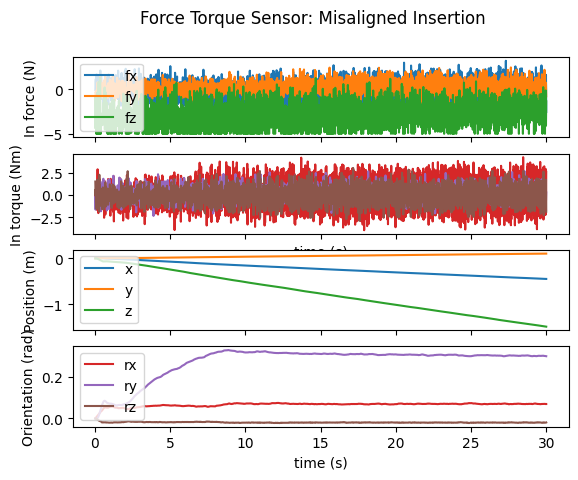

In [273]:
# @title Force torque data from misaligned plugging
# plot mj vs linear model
misaligned_sensor_data = np.array(sensor_data)
plt.figure(0)
# f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7, 1, sharex=True)
# f, (ax3, ax4, ax5, ax6, ax7) = plt.subplots(5, 1, sharex=True)
f, (ax3, ax4, ax5, ax6) = plt.subplots(4, 1, sharex=True)
plot_actions = np.array(all_actions)
print(plot_actions[:, 2].mean())
print(np.linalg.norm(misaligned_sensor_data[:, :6], axis=1).mean())
print(rpy)

# labels = ['fx', 'fy', 'fz']
# ls = 'dotted'
# for i in range(3):
#     color = plt.get_cmap('tab10')(i)
#     ax1.plot(t_vec[2:], misaligned_sensor_data[1:,i], color = color, label = labels[i-3])
# ax1.set_ylabel('Force (N)')
# ax1.legend(loc = 'lower left')

# labels = ['tx', 'ty', 'tz']
# for i in range(3):
#     i = i + 3
#     color = plt.get_cmap('tab10')(i)
#     ax2.plot(t_vec[2:], misaligned_sensor_data[1:,i], color = color, label = labels[i-3])
# ax2.set_ylabel('torque (Nm)');
# ax2.legend(loc = 'lower left')

labels = ['fx', 'fy', 'fz']
for i in range(3):
    i = i
    color = plt.get_cmap('tab10')(i)
    ax3.plot(t_vec[2:], plot_actions[1:,i], color = color, label = labels[i])
ax3.set_ylabel('In force (N)');
ax3.legend(loc = 'lower left')

labels = ['tx', 'ty', 'tz']
for i in range(3):
    i = i + 3
    color = plt.get_cmap('tab10')(i)
    ax4.plot(t_vec[2:], plot_actions[1:,i], color = color, label = labels[i-3])
ax4.set_xlabel('time (s)')
ax4.set_ylabel('In torque (Nm)');

labels = ['x', 'y', 'z']
for i in range(3):
    i = i
    color = plt.get_cmap('tab10')(i)
    ax5.plot(t_vec[2:], misaligned_sensor_data[1:,i+6], color = color, label = labels[i])
ax5.set_ylabel('Position (m)');
ax5.legend(loc = 'lower left')

labels = ['rx', 'ry', 'rz']
for i in range(3):
    i = i + 3
    color = plt.get_cmap('tab10')(i)
    ax6.plot(t_vec[2:], misaligned_sensor_data[1:,i+6], color = color, label = labels[i-3])
ax6.set_ylabel('Orientation (rad)');
ax6.legend(loc = 'lower left')


# ax7.plot(t_vec[2:], np.linalg.norm(misaligned_sensor_data[1:,6:12], axis=1), label="pos")
# ax7.plot(t_vec[2:], np.linalg.norm(misaligned_sensor_data[1:,12:18], axis=1), label="vel")
# ax7.legend()
# ax7.set_ylabel('state norm')
ax6.set_xlabel('time (s)')


f.suptitle('Force Torque Sensor: Misaligned Insertion');

-2.855091
34.7519384717122
[0.066 0.293 0.   ]


<Figure size 640x480 with 0 Axes>

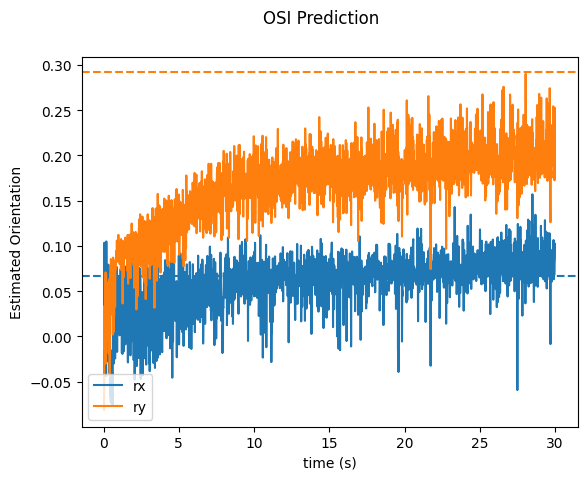

In [274]:
# @title Force torque data from misaligned plugging
# plot mj vs linear model
misaligned_sensor_data = np.array(sensor_data)
plt.figure(0)
f, ax1 = plt.subplots(1, 1, sharex=True)
# f, (ax3, ax4, ax5, ax6, ax7) = plt.subplots(5, 1, sharex=True)
plot_actions = np.array(all_actions)
print(plot_actions[:, 2].mean())
print(np.linalg.norm(misaligned_sensor_data[:, :6], axis=1).mean())
print(rpy)

labels = ['rx', 'ry']
for i in range(2):
    i = i
    color = plt.get_cmap('tab10')(i)
    ax1.plot(t_vec[2:], misaligned_sensor_data[1:,18+i], color = color, label = labels[i])
    ax1.axhline(y=rpy[i], color=color, linestyle='--')
ax1.set_ylabel('Estimated Orientation');
ax1.legend(loc = 'lower left')


ax1.set_xlabel('time (s)')


f.suptitle('OSI Prediction');

In [232]:
res_img = np.zeros((31, 31))
for i, r in enumerate(np.linspace(-0.3, 0.3, 31)):
    for j, p in enumerate(np.linspace(-0.3, 0.3, 31)):
        rpy = [r, p, 0]
        rotation = Rotation.from_euler('xyz', rpy)
        target_qpos = np.concatenate((rotation.apply([0, 0, -1.65]), rpy))
        sensor_data, all_actions, frames = run_model(rpy, duration=30, framerate=60, mj_steps_per_call=10, mode="true", vis=False)
        res_img[i,j] = np.linalg.norm(sensor_data[-1][6:9] - target_qpos[0:3])


Sim for 1801 steps
Time elapsed: 0.75026 seconds
Sim for 1801 steps
Time elapsed: 0.84275 seconds
Sim for 1801 steps
Time elapsed: 0.75849 seconds
Sim for 1801 steps
Time elapsed: 0.70141 seconds
Sim for 1801 steps
Time elapsed: 0.68433 seconds
Sim for 1801 steps
Time elapsed: 0.77184 seconds
Sim for 1801 steps
Time elapsed: 0.73039 seconds
Sim for 1801 steps
Time elapsed: 0.70275 seconds
Sim for 1801 steps
Time elapsed: 0.62509 seconds
Sim for 1801 steps
Time elapsed: 0.68264 seconds
Sim for 1801 steps
Time elapsed: 0.65634 seconds
Sim for 1801 steps
Time elapsed: 0.68804 seconds
Sim for 1801 steps
Time elapsed: 0.72909 seconds
Sim for 1801 steps
Time elapsed: 0.74622 seconds
Sim for 1801 steps
Time elapsed: 2.07880 seconds
Sim for 1801 steps
Time elapsed: 0.69965 seconds
Sim for 1801 steps
Time elapsed: 0.71860 seconds
Sim for 1801 steps
Time elapsed: 0.67214 seconds
Sim for 1801 steps
Time elapsed: 0.79307 seconds
Sim for 1801 steps
Time elapsed: 0.76919 seconds
Sim for 1801 steps
T

Time elapsed: 0.63662 seconds
Sim for 1801 steps
Time elapsed: 0.65666 seconds
Sim for 1801 steps
Time elapsed: 0.74232 seconds
Sim for 1801 steps
Time elapsed: 0.70711 seconds
Sim for 1801 steps
Time elapsed: 0.68886 seconds
Sim for 1801 steps
Time elapsed: 0.68354 seconds
Sim for 1801 steps
Time elapsed: 0.68225 seconds
Sim for 1801 steps
Time elapsed: 0.64854 seconds
Sim for 1801 steps
Time elapsed: 0.68469 seconds
Sim for 1801 steps
Time elapsed: 0.67689 seconds
Sim for 1801 steps
Time elapsed: 0.64639 seconds
Sim for 1801 steps
Time elapsed: 0.68878 seconds
Sim for 1801 steps
Time elapsed: 0.69620 seconds
Sim for 1801 steps
Time elapsed: 0.68825 seconds
Sim for 1801 steps
Time elapsed: 0.73950 seconds
Sim for 1801 steps
Time elapsed: 0.68199 seconds
Sim for 1801 steps
Time elapsed: 0.68980 seconds
Sim for 1801 steps
Time elapsed: 0.70507 seconds
Sim for 1801 steps
Time elapsed: 0.68426 seconds
Sim for 1801 steps
Time elapsed: 0.64658 seconds
Sim for 1801 steps
Time elapsed: 0.6969

Time elapsed: 0.71971 seconds
Sim for 1801 steps
Time elapsed: 0.71537 seconds
Sim for 1801 steps
Time elapsed: 0.69661 seconds
Sim for 1801 steps
Time elapsed: 0.70994 seconds
Sim for 1801 steps
Time elapsed: 0.67210 seconds
Sim for 1801 steps
Time elapsed: 0.68468 seconds
Sim for 1801 steps
Time elapsed: 0.66834 seconds
Sim for 1801 steps
Time elapsed: 0.67854 seconds
Sim for 1801 steps
Time elapsed: 0.71567 seconds
Sim for 1801 steps
Time elapsed: 0.69134 seconds
Sim for 1801 steps
Time elapsed: 0.67943 seconds
Sim for 1801 steps
Time elapsed: 0.66142 seconds
Sim for 1801 steps
Time elapsed: 0.68206 seconds
Sim for 1801 steps
Time elapsed: 0.69002 seconds
Sim for 1801 steps
Time elapsed: 0.69973 seconds
Sim for 1801 steps
Time elapsed: 0.68436 seconds
Sim for 1801 steps
Time elapsed: 0.69746 seconds
Sim for 1801 steps
Time elapsed: 0.67232 seconds
Sim for 1801 steps
Time elapsed: 0.67344 seconds
Sim for 1801 steps
Time elapsed: 0.68539 seconds
Sim for 1801 steps
Time elapsed: 0.6899

Time elapsed: 0.72019 seconds
Sim for 1801 steps
Time elapsed: 0.68816 seconds
Sim for 1801 steps
Time elapsed: 0.68714 seconds
Sim for 1801 steps
Time elapsed: 0.70471 seconds
Sim for 1801 steps
Time elapsed: 0.72128 seconds
Sim for 1801 steps
Time elapsed: 0.70292 seconds
Sim for 1801 steps
Time elapsed: 0.68017 seconds
Sim for 1801 steps
Time elapsed: 0.70450 seconds
Sim for 1801 steps
Time elapsed: 0.73019 seconds
Sim for 1801 steps
Time elapsed: 0.67112 seconds
Sim for 1801 steps
Time elapsed: 0.70273 seconds
Sim for 1801 steps
Time elapsed: 0.67671 seconds
Sim for 1801 steps
Time elapsed: 0.69783 seconds
Sim for 1801 steps
Time elapsed: 2.12128 seconds
Sim for 1801 steps
Time elapsed: 0.75673 seconds
Sim for 1801 steps
Time elapsed: 0.73818 seconds
Sim for 1801 steps
Time elapsed: 0.73233 seconds
Sim for 1801 steps
Time elapsed: 0.69963 seconds
Sim for 1801 steps
Time elapsed: 0.65421 seconds
Sim for 1801 steps
Time elapsed: 0.68770 seconds
Sim for 1801 steps
Time elapsed: 0.6904

Time elapsed: 0.63643 seconds
Sim for 1801 steps
Time elapsed: 0.63235 seconds
Sim for 1801 steps
Time elapsed: 0.68391 seconds
Sim for 1801 steps
Time elapsed: 0.66476 seconds
Sim for 1801 steps
Time elapsed: 0.65247 seconds
Sim for 1801 steps
Time elapsed: 0.65006 seconds
Sim for 1801 steps
Time elapsed: 0.64057 seconds
Sim for 1801 steps
Time elapsed: 0.62773 seconds
Sim for 1801 steps
Time elapsed: 0.66069 seconds
Sim for 1801 steps
Time elapsed: 0.64814 seconds
Sim for 1801 steps
Time elapsed: 0.70063 seconds
Sim for 1801 steps
Time elapsed: 0.66971 seconds
Sim for 1801 steps
Time elapsed: 0.64795 seconds
Sim for 1801 steps
Time elapsed: 0.63241 seconds
Sim for 1801 steps
Time elapsed: 0.61761 seconds
Sim for 1801 steps
Time elapsed: 0.62639 seconds
Sim for 1801 steps
Time elapsed: 0.61356 seconds
Sim for 1801 steps
Time elapsed: 0.61769 seconds
Sim for 1801 steps
Time elapsed: 0.62229 seconds
Sim for 1801 steps
Time elapsed: 0.64015 seconds
Sim for 1801 steps
Time elapsed: 0.6780

Time elapsed: 0.67300 seconds
Sim for 1801 steps
Time elapsed: 0.67604 seconds
Sim for 1801 steps
Time elapsed: 0.67793 seconds
Sim for 1801 steps
Time elapsed: 0.66356 seconds
Sim for 1801 steps
Time elapsed: 0.65786 seconds
Sim for 1801 steps
Time elapsed: 0.67989 seconds
Sim for 1801 steps
Time elapsed: 0.68787 seconds
Sim for 1801 steps
Time elapsed: 0.68805 seconds
Sim for 1801 steps
Time elapsed: 0.60237 seconds
Sim for 1801 steps
Time elapsed: 0.66485 seconds
Sim for 1801 steps
Time elapsed: 0.71617 seconds
Sim for 1801 steps
Time elapsed: 2.08876 seconds
Sim for 1801 steps
Time elapsed: 0.73624 seconds
Sim for 1801 steps
Time elapsed: 0.69663 seconds
Sim for 1801 steps
Time elapsed: 0.70027 seconds
Sim for 1801 steps
Time elapsed: 0.70373 seconds
Sim for 1801 steps
Time elapsed: 0.66728 seconds
Sim for 1801 steps
Time elapsed: 0.64570 seconds
Sim for 1801 steps
Time elapsed: 0.66164 seconds
Sim for 1801 steps
Time elapsed: 0.63050 seconds
Sim for 1801 steps
Time elapsed: 0.6296

Time elapsed: 0.56622 seconds
Sim for 1801 steps
Time elapsed: 0.61838 seconds
Sim for 1801 steps
Time elapsed: 0.53449 seconds
Sim for 1801 steps
Time elapsed: 0.61975 seconds
Sim for 1801 steps
Time elapsed: 0.62729 seconds
Sim for 1801 steps
Time elapsed: 0.55113 seconds
Sim for 1801 steps
Time elapsed: 0.60302 seconds
Sim for 1801 steps
Time elapsed: 0.56622 seconds
Sim for 1801 steps
Time elapsed: 0.66511 seconds
Sim for 1801 steps
Time elapsed: 0.66991 seconds
Sim for 1801 steps
Time elapsed: 0.56476 seconds
Sim for 1801 steps
Time elapsed: 0.67385 seconds
Sim for 1801 steps
Time elapsed: 0.63085 seconds
Sim for 1801 steps
Time elapsed: 0.63576 seconds
Sim for 1801 steps
Time elapsed: 0.66947 seconds
Sim for 1801 steps
Time elapsed: 0.64459 seconds
Sim for 1801 steps
Time elapsed: 0.67113 seconds
Sim for 1801 steps
Time elapsed: 0.64775 seconds
Sim for 1801 steps
Time elapsed: 0.65815 seconds
Sim for 1801 steps
Time elapsed: 0.68230 seconds
Sim for 1801 steps
Time elapsed: 0.6578

607
0.631633714880333


Text(0.5, 1.0, 'UP-Zero Plugging Success')

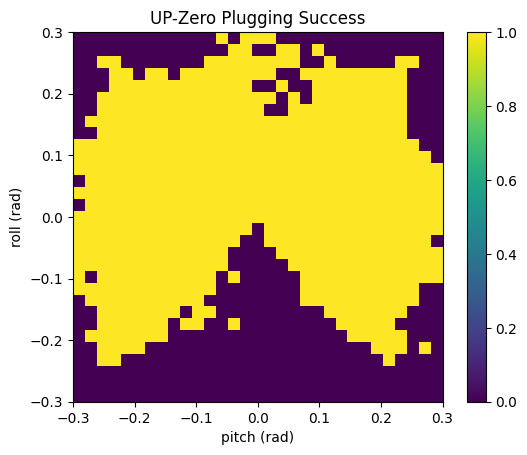

In [238]:
#np.save("up-true_image", res_img)
res_img = np.load("up-zero_image.npy")
plt.figure(1)
thresh = 0.5
print(np.sum(res_img < thresh))
print(np.sum(res_img < thresh) / res_img.shape[0]**2)
plt.imshow(res_img < thresh, extent=[-0.3, 0.3, -0.3, 0.3])
plt.xlabel('pitch (rad)')
plt.ylabel('roll (rad)')
plt.colorbar()
plt.title('UP-Zero Plugging Success')